In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd

# ESIO Imports
import esio
import esiodata as ed

import dask


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'model', 'extent_test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runType = 'forecast'
variables = ['sic']
cvar = variables[0]
test_plots = False

In [3]:
# Define models
models_2_process = list(E.model.keys())
models_2_process = [x for x in models_2_process if x!='piomas'] # remove some models
# models_2_process = ['ukmetofficesipn','isaccnr','hcmr','ecmwf','cma']
# models_2_process = ['cma']
models_2_process

['cma']

In [4]:
# Load in Obs
da_obs_in = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [5]:
# from dask.distributed import Client, progress
# client = Client(processes=12)
# client

cma


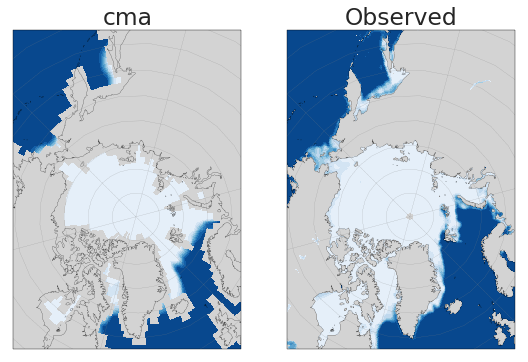

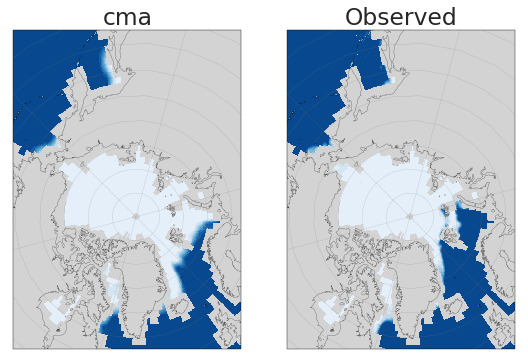

In [12]:
for (i, c_model) in enumerate(models_2_process):
    print(c_model)
    
    # Output temp dir
    out_dir =  os.path.join(data_dir, 'model', c_model , 'forecast', 'agg_nc')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Load in Model
    model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
    ds_model = xr.open_mfdataset(model_forecast, 
                                         chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
    ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

    # Set attributes
    ds_model.attrs['model_label'] = E.model[c_model]['model_label']
    ds_model.attrs['model_grid_file'] = E.model[c_model]['grid']
    ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']


    # Select by variable
    da_mod_in = ds_model[cvar]

    if test_plots:
        # Plot Original extents
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
        (f, axes) = esio.multi_polar_axis(ncols=2, nrows=1, Nplots=3, sizefcter=3)
        datemp = da_mod_in.isel(ensemble=0).isel(init_time=60).isel(fore_time=1)
        p = datemp.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
        # Calc extents
        axes[0].set_title(c_model)

        p = da_obs_in.sic.sel(time=(datemp.init_time+datemp.fore_time)).plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
        axes[1].set_title('Observed')
        f.savefig(os.path.join(fig_dir, c_model+'_orig.png'))

        
        
    # Mask out to common extent (both observations and model have non-null values)
    (da_obs, da_mod) = esio.mask_common_extent(da_obs_in, da_mod_in)

    
    
    ## Union of Land masks from model observed
    if test_plots:
        # Plot Common extents
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
        (f, axes) = esio.multi_polar_axis(ncols=2, nrows=1, Nplots=3, sizefcter=3)
        datemp = da_mod.sic.isel(ensemble=0).isel(init_time=60).isel(fore_time=1)
        p = datemp.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
        # Calc extents
        axes[0].set_title(c_model)

        p = da_obs.sic.sel(time=(datemp.init_time+datemp.fore_time)).plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
        axes[1].set_title('Observed')
        f.savefig(os.path.join(fig_dir, c_model+'_adjusted.png'))
        break

    
    # Calculate Sea Ice << EXTENT >>
    da_obs_avg = esio.calc_extent(da_obs.sic, ds_region)
    da_mod_avg = esio.calc_extent(da_mod.sic, ds_region)

    da_mod_avg #.fore_time.values.astype('timedelta64[D]')

    # Force model and observations to have the same temporal time step (and slice or average)
    # Get model and obs time step
    dt_obs = (da_obs_avg.time[1] - da_obs_avg.time[0]).values # Time slices
    dt_mod = (da_mod_avg.fore_time[1] - da_mod_avg.fore_time[0]).values
    freq_dict = {np.timedelta64(86400000000000,'ns'):'1D', np.timedelta64(1,'M'):'MS'} # TODO: find a way to automate this....

    # Aggregate to larger time step
    if dt_obs > dt_mod:
        # Aggregate model to obs
        da_mod_avg_agg = da_mod_avg.resample(fore_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='fore_time') # on fore_time
        da_mod_avg_agg = da_mod_avg_agg.resample(init_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='init_time') # on init_time
        da_obs_avg_agg = da_obs_avg # pass through
    elif dt_obs < dt_mod:
        # Aggregate obs to model
        da_obs_avg_agg = da_obs_avg.resample(time=freq_dict[dt_mod], label='left', keep_attrs=True).mean(dim='time')
        da_mod_avg_agg = da_mod_avg # pass through
    else: # They are equal, do nothing
        da_obs_avg_agg = da_obs_avg # pass through
        da_mod_avg_agg = da_mod_avg # pass through

    #da_obs_avg_agg.time.min().values, da_obs_avg_agg.time.max().values
    #da_mod_avg_agg.init_time.min().values, da_mod_avg_agg.init_time.max().values

    # Trim to common time periods
    #%autoreload
    (ds_obs_trim, ds_mod_trim) = esio.trim_common_times(da_obs_avg_agg, da_mod_avg_agg, freq=freq_dict[dt_obs])

    # Drop coords here (not sure why they are added)
    ds_obs_trim = ds_obs_trim.drop(['fore_time','init_time'])

    # Loop and build dask graph, then compute all metrics at once
    print('Building dask graph....')
    da_l = []
    for (j, it) in enumerate(ds_mod_trim.init_time):
        c_obs = ds_obs_trim.sel(time = (ds_mod_trim.init_time.sel(init_time=it)  
                                        + ds_mod_trim.fore_time).rename({'fore_time':'time'}) )
        c_obs = c_obs.rename({'time':'fore_time'})
        c_obs['fore_time'] = ds_mod_trim.fore_time
        c_obs.coords['ensemble'] = -1 # set to -1 for obs
        
        da_ens = []
        for (i, e) in enumerate(ds_mod_trim.ensemble):
            c_mod = ds_mod_trim.sel(init_time=it).sel(ensemble=e)
            c_mod.coords['ensemble'] = e

            da_ens.append(c_mod)
            
        # Done with all models, concat by ensemble (with obs)
        c_ds = xr.concat([c_obs] + da_ens, dim='ensemble')
        
        # append to list of init_times
        da_l.append(c_ds)
        
#         if j>3:
#             break

    mrg = xr.concat(da_l, dim='init_time')
    mrg.name = 'sic'
    
    # Set panArctic extents that equal 0 to missing
    # This occurs if all model values for a time are missing, sum() returns missing
    # Usually occurs when a model changes number of ensemble members, or forecast lead time, and files are merged together
    # Nans are filled in the missing gaps.
    mrg = mrg.where(mrg>0)

    
    from dask.diagnostics import ProgressBar
    dask.set_options(get=dask.threaded.get)
    print('Dask graph built....starting computations...')
    with ProgressBar():
        mrg.to_netcdf(os.path.join(out_dir, c_model+'_extent.nc')) # to_netcdf calls compute
    print('Done')    
        
#     print('Dask graph built....starting computations...')
#     mrg = mrg.persist()
#     futures = client.scatter(dict(x.dask))  # scatter chunks
#     progress(mrg)
#     %time mrg = mrg.compute()
#     mrg.to_netcdf(os.path.join(out_dir, c_model+'_extent.nc')) 
#     print('Done')

In [7]:
# Multie threaded
# 1min 52.8s
# Distributed 12 proceses
# 45s
# Distributed 24 proceses
# 45s (no difference)

In [8]:
# Plot most recent data

<xarray.DataArray 'sic' ()>
array(135417)


NameError: name 'ds_obs_trim' is not defined

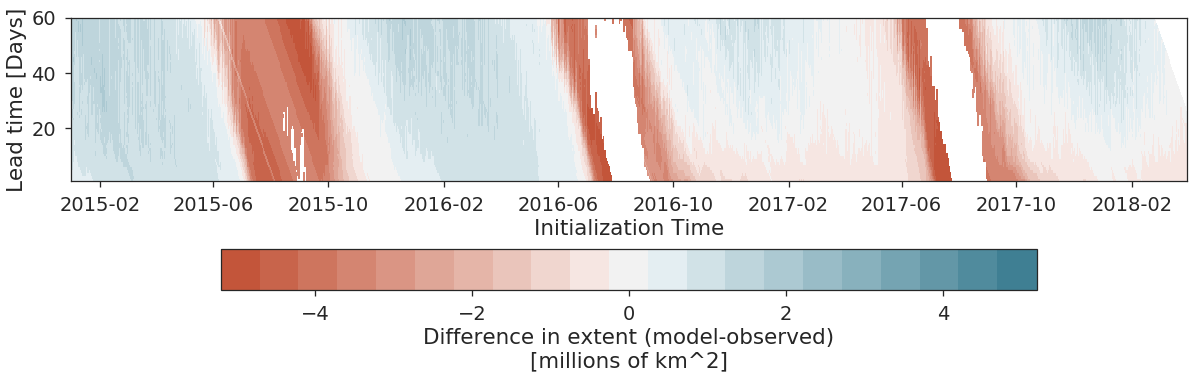

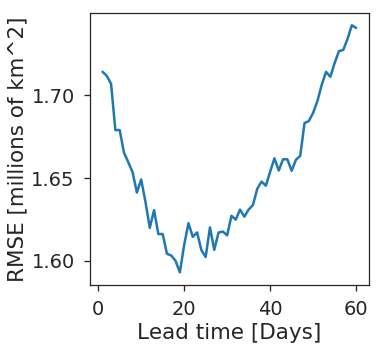

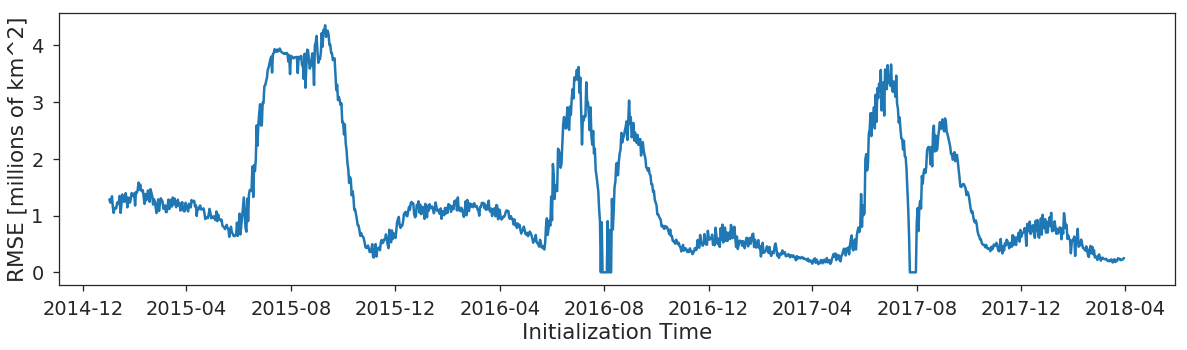

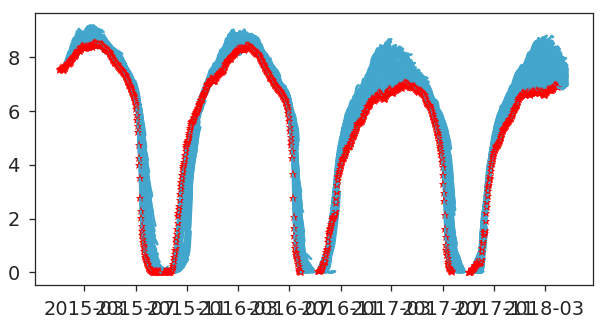

In [9]:
ds_mrg = xr.open_dataset(os.path.join(out_dir, c_model+'_extent.nc'))
print(ds_mrg.sic.notnull().sum())

cmap_diff = matplotlib.colors.ListedColormap(sns.diverging_palette(20,  220, n=21))

MOdiff = (ds_mrg.sic.sel(ensemble=0) - ds_mrg.sic.sel(ensemble=-1) )
abs_max = np.max([MOdiff.min()*-1, MOdiff.max()])

plt.figure(figsize=(20,5))

plt.pcolormesh(ds_mrg.init_time.values, ds_mrg.fore_time.values.astype('timedelta64[D]').astype('int'), MOdiff.T.values,
              cmap=cmap_diff, vmin=-1*abs_max, vmax=abs_max)
plt.ylabel('Lead time [Days]')
plt.xlabel('Initialization Time')
cb = plt.colorbar(orientation='horizontal', label='Difference in extent (model-observed)\n[millions of km^2]', pad=0.25)


rmse_fore_time = np.sqrt(((MOdiff**2).sum(dim='init_time').values)/MOdiff.init_time.size)
plt.figure(figsize=(5,5))
plt.plot(MOdiff.fore_time.values.astype('timedelta64[D]').astype('int'), rmse_fore_time)
plt.ylabel('RMSE [millions of km^2]')
plt.xlabel('Lead time [Days]')

rmse_init_time = np.sqrt(((MOdiff**2).sum(dim='fore_time').values)/MOdiff.fore_time.size)
plt.figure(figsize=(20,5))
plt.plot(MOdiff.init_time.values, rmse_init_time)
plt.ylabel('RMSE [millions of km^2]')
plt.xlabel('Initialization Time')



# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
esio.plot_reforecast(ds=ds_mrg.sel(ensemble=slice(0,ds_mrg.ensemble.size)).sic, axin=ax1, labelin=ds_model.model_label,
                     color='cycle_ensemble', marker=None)
ds_obs_trim.plot(label='NSIDC NRT', color='k')
# ds_ext.Extent.plot(label='NSIDC V3', color='m')
ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
f.autofmt_xdate()
plt.title('')

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import dask

# @dask.delayed
# def get_rmse(y_actual, y_predicted):
#     return mean_squared_error(y_actual, y_predicted)

In [ ]:
 # Get observational mean and sigma
# (mu, sigma) = esio.clim_mu_sigma(da_obs_avg_agg, method='MK')

In [ ]:
# c_nrmse = esio.NRMSE(ds_mod_trim, da_obs_avg_mon_X, sigma)
# print(c_nrmse)

In [ ]:
#NRMSE is following the same pattern per months as Hawkins et al. 2016.
# f, ax1 = plt.subplots(1,1)
# f.set_size_inches(10, 6)
# c_nrmse.plot(ax=ax1)